# Assignment 2
## Facial Point Detection

This assignment approaches the computer vision problem of detecting facial keypoints in an image using deep learning techniques.

The training dataset consists of 7,049 96x96 gray-scale images. For each image, we're supposed learn to find the correct position (the ``x`` and ``y`` coordinates) of 15 2D keypoints, such as ``left_eye_center, right_eye_outer_corner, mouth_center_bottom_lip``, and so on. For some of the keypoints we only have about 2,000 labels, while other keypoints have more than 7,000 labels available for training.

In the following lines we provide a simple solution. This model can be used to provide a baseline result to be used for comparison.

The objectives of this assignment are:
+ To develop a better solution by changing the baseline model.
+ To increase performance by using several tricks:
    + Data augmentation: flipped images, greylevel image editing, etc.
    + Changing learning rate and momentum over time.
    + Using regularization techniques such as Dropout.
    + Instead of training a single model, train a few specialist networks, with each one predicting a different subset of target values (f.e. eye features, mouth features, etc.).
    + Etc.

> You will need **GPU computation**. Consider the use of Colab!
    
At the end of the notebook you must report:
+ What is the best result you got when testing.
+ What architecture and tricks you used for that result.

The final model can be developed in Tensorflow or in Keras.

In [ ]:
#connect to Drive to retrieve data

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!ls drive/MyDrive/PPIpred_scripts/

Databases  Model  test.csv  training.csv


In [ ]:
# in order to have consistent results:
import random

random.seed(10)

In [ ]:
%matplotlib inline

import numpy as np
import matplotlib
from matplotlib import pyplot
import os
import time

from pandas import DataFrame
from pandas.io.parsers import read_csv
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
import tensorflow as tf

Upload the `test.csv` and `training.csv` files that you can download from campus virtual.

In [ ]:
# loading data

FTRAIN = 'drive/MyDrive/training.csv'
FTEST = 'drive/MyDrive/test.csv'

def load(test = False, cols = None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep = ' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    df = df.dropna()  # drop all rows that have missing values in them
    print("\n")
    print(df)

    X = np.row_stack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    print("Number of samples in", fname, ":",len(X))
    print("Labels: ", df.columns.tolist())

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None
    return X.reshape(df.shape[0],96,96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)



      left_eye_center_x  left_eye_center_y  right_eye_center_x  \
0             66.033564          39.002274           30.227008   
1             64.332936          34.970077           29.949277   
2             65.057053          34.909642           30.903789   
3             65.225739          37.261774           32.023096   
4             66.725301          39.621261           32.244810   
...                 ...                ...                 ...   
2277          67.180378          35.816373           33.239956   
2278          65.724490          36.301020           25.377551   
2281          68.430866          38.651975           28.895857   
2282          64.152180          30.691592           27.000898   
2283          66.683755          34.483429           30.784490   

      right_eye_center_y  left_eye_inner_corner_x  left_eye_inner_corner_y  \
0              36.421678                59.582075                39.647423   
1              33.448715                58.856170

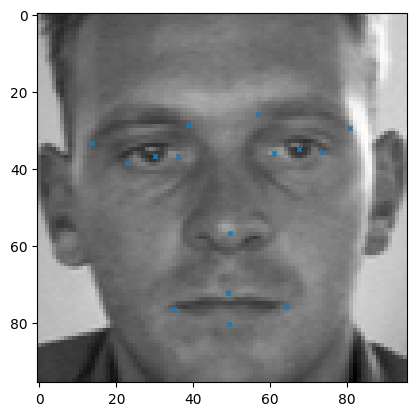

In [ ]:
# loading data

X, y = load()

print("\n Sample image with labels:")
plot_sample(X[13],y[13])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(1498, 96, 96, 1)
(321, 96, 96, 1)
(321, 96, 96, 1)


In [ ]:
print(y_test.shape)
print(y_train.shape)
print(y_valid.shape)

(321, 30)
(1498, 30)
(321, 30)


In [ ]:
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 48, 48, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 24, 24, 64)        0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 36864)             0         
                                                                 
 dense (Dense)               (None, 30)                1

In [ ]:
batch_size = 128
epochs = 50

from keras import backend as K

def root_mean_squared_error(y_true, y_pred):
        return K.sqrt(K.mean(K.square(y_pred - y_true)))

model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 14s 164ms/step - loss: 0.3483 - val_loss: 0.1346
Epoch 2/50
11/11 [==============================] - 1s 50ms/step - loss: 0.1430 - val_loss: 0.1220
Epoch 3/50
11/11 [==============================] - 1s 48ms/step - loss: 0.1066 - val_loss: 0.0835
Epoch 4/50
11/11 [==============================] - 1s 51ms/step - loss: 0.0775 - val_loss: 0.0694
Epoch 5/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0626 - val_loss: 0.0616
Epoch 6/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0549 - val_loss: 0.0609
Epoch 7/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0503 - val_loss: 0.0575
Epoch 8/50
11/11 [==============================] - 0s 39ms/step - loss: 0.0447 - val_loss: 0.0499
Epoch 9/50
11/11 [==============================] - 0s 38ms/step - loss: 0.0429 - val_loss: 0.0543
Epoch 10/50
11/11 [==============================] - 0s 40ms/step - loss: 0.0426 - val_loss: 0.0450
Epoch 1

In [ ]:
y_new = model.predict(x_valid)

def rmse_pixel(y_true, y_pred):
        return np.sqrt(np.mean(np.square(y_pred*48 - y_true*48)))

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 7ms/step
Mean pixel error:  1.8663657


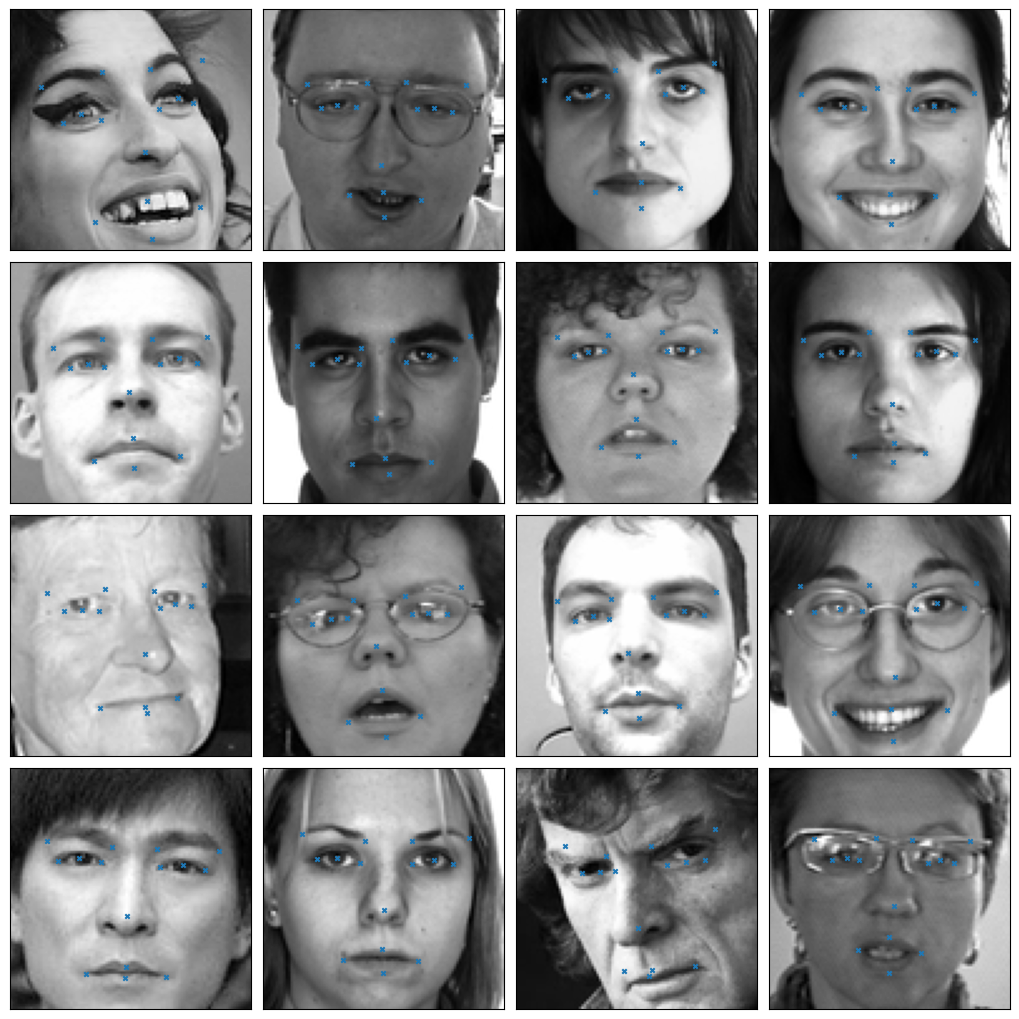

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_new[i])
pyplot.show()

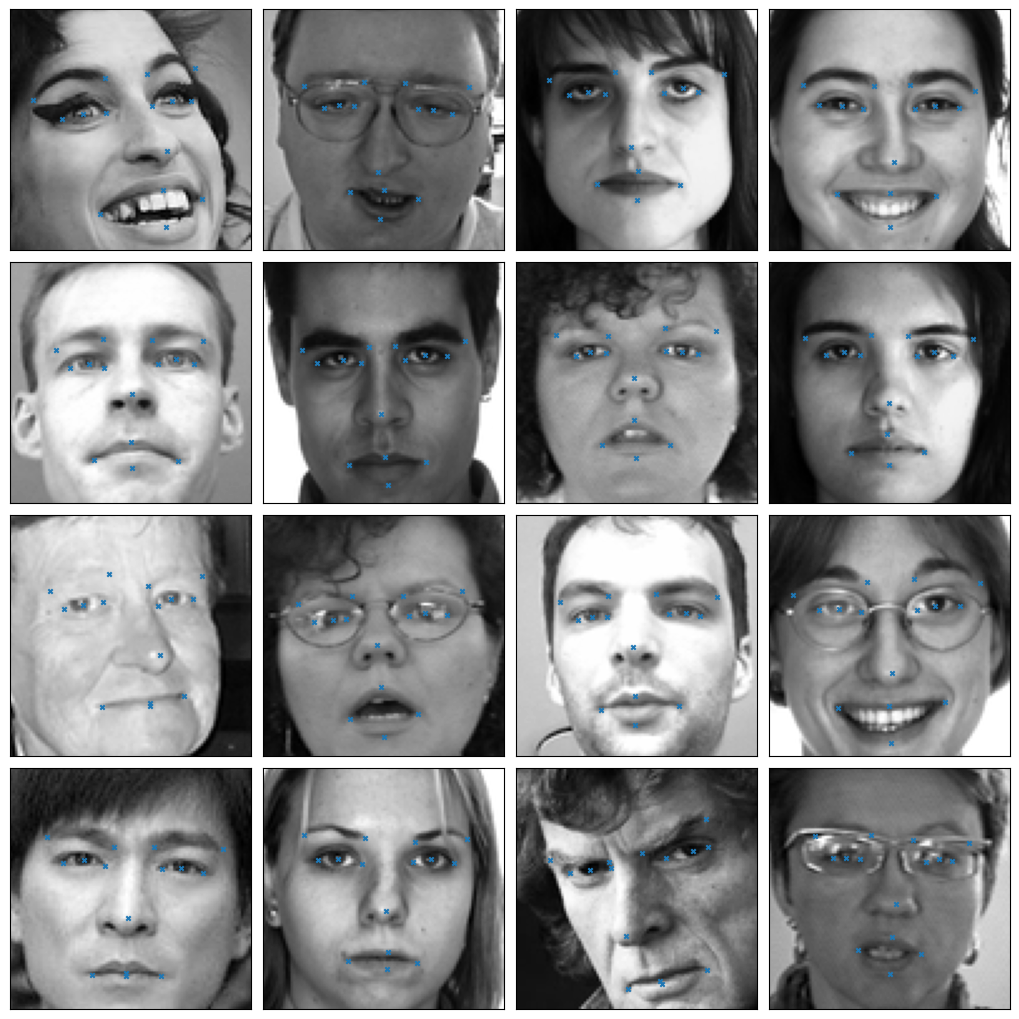

In [ ]:
fig = pyplot.figure(figsize=(10, 10))
fig.subplots_adjust(
    left=0, right=1, bottom=0, top=1, hspace=0.05, wspace=0.05)

for i in range(16):
    ax = fig.add_subplot(4, 4, i + 1, xticks=[], yticks=[])
    plot_sample(x_valid[i,:,:,0],y_valid[i])

pyplot.show()

# Your solution

### First approach - Adding complexity to the model

My first approach has consisted on adding complexity to the model by adding more Convolutional layers in order to capture hierarchical features, also  making this layers more complex by adding more neurons to them. I also applied a regularization procedure in order to avoid overfitting by adding a droout layer of 0.5.

After trying different layers, I have come to the conclusion that having 3 convolutional 2D layers is the most optimal architecture, which gives a mean pixel error between 1.6 and 1.4. I experimented with different depths in the convolutional layers.

In [ ]:
# your code here

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

# increase model complexity
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #add dropout for regularization
        layers.Dropout(0.5),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_44 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d_42 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_45 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_43 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_46 (Conv2D)          (None, 24, 24, 256)       295168    
                                                                 
 max_pooling2d_44 (MaxPooli  (None, 12, 12, 256)     

In [ ]:
batch_size = 10
epochs = 50
model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(x_train, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
135/135 [==============================] - 2s 10ms/step - loss: 0.0839 - val_loss: 0.0624
Epoch 2/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0574 - val_loss: 0.0478
Epoch 3/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0490 - val_loss: 0.0501
Epoch 4/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0442 - val_loss: 0.0551
Epoch 5/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0421 - val_loss: 0.0443
Epoch 6/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0396 - val_loss: 0.0374
Epoch 7/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0371 - val_loss: 0.0363
Epoch 8/50
135/135 [==============================] - 1s 8ms/step - loss: 0.0358 - val_loss: 0.0370
Epoch 9/50
135/135 [==============================] - 1s 11ms/step - loss: 0.0345 - val_loss: 0.0346
Epoch 10/50
135/135 [==============================] - 1s 9ms/step - loss: 0.0348 - val_loss: 0.03

In [ ]:
y_new = model.predict(x_valid)

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 6ms/step
Mean pixel error:  1.5580422


With the same model architecture I implemented early stopping in order to not overfit, as we can see from the loss in the previous training that it gets hard to improve.

In [ ]:
# your code here

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

# increase model complexity
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #add dropout for regularization
        layers.Dropout(0.5),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential_15"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_47 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d_45 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_48 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_46 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_49 (Conv2D)          (None, 24, 24, 256)       295168    
                                                                 
 max_pooling2d_47 (MaxPooli  (None, 12, 12, 256)     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

batch_size = 10
epochs = 100
model.compile(loss=root_mean_squared_error, optimizer="adam")

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train your model with the learning rate scheduler and early stopping
history = model.fit(
    x_train, y_train,
    epochs=50,
    callbacks=[early_stopping],
    validation_data=(x_valid, y_valid)
)

Epoch 1/50
47/47 [==============================] - 2s 25ms/step - loss: 0.1117 - val_loss: 0.0693
Epoch 2/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0663 - val_loss: 0.0622
Epoch 3/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0595 - val_loss: 0.0512
Epoch 4/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0505 - val_loss: 0.0450
Epoch 5/50
47/47 [==============================] - 1s 22ms/step - loss: 0.0455 - val_loss: 0.0410
Epoch 6/50
47/47 [==============================] - 1s 24ms/step - loss: 0.0421 - val_loss: 0.0405
Epoch 7/50
47/47 [==============================] - 1s 24ms/step - loss: 0.0385 - val_loss: 0.0355
Epoch 8/50
47/47 [==============================] - 1s 21ms/step - loss: 0.0374 - val_loss: 0.0397
Epoch 9/50
47/47 [==============================] - 1s 22ms/step - loss: 0.0364 - val_loss: 0.0343
Epoch 10/50
47/47 [==============================] - 1s 22ms/step - loss: 0.0334 - val_loss: 0.0327
Epoch 11/

In [ ]:
y_new = model.predict(x_valid)

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 6ms/step
Mean pixel error:  1.522418


We can see that with early stopping we had a little bit of improvement in the mean pixel error. Nevertheless, depending on the initialization of the weights this does not happen, sometimes model 1) is better than model 2) .

Again with the origial model architecture I have implemented learning rate scheduling in order to reduce the lr over time and see if a diminish of the lr is a better approach

In [ ]:
# your code here

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

# increase model complexity
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #add dropout for regularization
        layers.Dropout(0.5),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_20 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d_20 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_21 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_21 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_22 (Conv2D)          (None, 24, 24, 256)       295168    
                                                                 
 max_pooling2d_22 (MaxPooli  (None, 12, 12, 256)      

In [ ]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler


# Define initial learning rate and momentum
initial_learning_rate = 0.01
initial_momentum = 0.9

## CHANGING OPTIMIZER
# Create an optimizer with initial learning rate and momentum
#sgd_optimizer = SGD(learning_rate=initial_learning_rate, momentum=initial_momentum)

# Create an optimizer with initial learning rate
adam_optimizer = Adam(learning_rate=initial_learning_rate)

# Compile your model with the optimizer
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.

    Parameters:
    - epoch: Current epoch.

    Returns:
    - learning_rate: Updated learning rate for the epoch.
    """
    # You can define your own schedule here
    if epoch < 20:
        return initial_learning_rate
    else:
        return initial_learning_rate * 0.1

# Create a learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Train your model with the learning rate scheduler
history = model.fit(x_train, y_train, epochs=50, callbacks=[lr_scheduler], validation_data=(x_valid, y_valid))


Epoch 1/50
47/47 [==============================] - 3s 28ms/step - loss: 202.3225 - val_loss: 0.0050 - lr: 0.0100
Epoch 2/50
47/47 [==============================] - 1s 23ms/step - loss: 0.0054 - val_loss: 0.0044 - lr: 0.0100
Epoch 3/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0056 - val_loss: 0.0047 - lr: 0.0100
Epoch 4/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0057 - val_loss: 0.0046 - lr: 0.0100
Epoch 5/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0055 - val_loss: 0.0044 - lr: 0.0100
Epoch 6/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0055 - val_loss: 0.0049 - lr: 0.0100
Epoch 7/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0054 - val_loss: 0.0051 - lr: 0.0100
Epoch 8/50
47/47 [==============================] - 1s 21ms/step - loss: 0.0055 - val_loss: 0.0044 - lr: 0.0100
Epoch 9/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0054 - val_loss: 0.0045 - l

In the code it can be seen that I also tried diferent optimizers, but Adam was still better.

Regarding the performance of the model diminishing the lr, we can see that the mean pixel error gets even higher, indicating that a smaller lr gets to a local minimum and not to the most optimal solution.

In [ ]:
y_new = model.predict(x_valid)

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 6ms/step
Mean pixel error:  2.9480846


Finally, using the same model architecture, as a training routine I have decided to combine early stopping with lr scheduler. It turns out that the mean pixel error gets even higher.

In [ ]:
# your code here

# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

# increase model complexity
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #add dropout for regularization
        layers.Dropout(0.5),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_23 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d_23 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_24 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_24 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_25 (Conv2D)          (None, 24, 24, 256)       295168    
                                                                 
 max_pooling2d_25 (MaxPooli  (None, 12, 12, 256)      

In [ ]:
# Define initial learning rate
initial_learning_rate = 0.01

# Create an optimizer with initial learning rate
adam_optimizer = Adam(learning_rate=initial_learning_rate)

# Compile your model with the optimizer
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')

# Define a learning rate schedule function
def lr_schedule(epoch):
    """
    Learning rate schedule function.

    Parameters:
    - epoch: Current epoch.

    Returns:
    - learning_rate: Updated learning rate for the epoch.
    """
    # You can define your own schedule here
    if epoch < 10:
        return initial_learning_rate
    else:
        return initial_learning_rate * 0.1

# Create a learning rate scheduler
lr_scheduler = LearningRateScheduler(lr_schedule)

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train your model with the learning rate scheduler and early stopping
history = model.fit(
    x_train, y_train,
    epochs=50,
    callbacks=[lr_scheduler, early_stopping],
    validation_data=(x_valid, y_valid)
)

Epoch 1/50
47/47 [==============================] - 2s 24ms/step - loss: 73.8584 - val_loss: 0.1760 - lr: 0.0100
Epoch 2/50
47/47 [==============================] - 1s 20ms/step - loss: 0.1649 - val_loss: 0.1547 - lr: 0.0100
Epoch 3/50
47/47 [==============================] - 1s 19ms/step - loss: 0.1417 - val_loss: 0.1302 - lr: 0.0100
Epoch 4/50
47/47 [==============================] - 1s 20ms/step - loss: 0.1173 - val_loss: 0.1060 - lr: 0.0100
Epoch 5/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0941 - val_loss: 0.0839 - lr: 0.0100
Epoch 6/50
47/47 [==============================] - 1s 21ms/step - loss: 0.0736 - val_loss: 0.0649 - lr: 0.0100
Epoch 7/50
47/47 [==============================] - 1s 19ms/step - loss: 0.0562 - val_loss: 0.0491 - lr: 0.0100
Epoch 8/50
47/47 [==============================] - 1s 20ms/step - loss: 0.0422 - val_loss: 0.0366 - lr: 0.0100
Epoch 9/50
47/47 [==============================] - 1s 23ms/step - loss: 0.0312 - val_loss: 0.0269 - lr

In [ ]:
y_new = model.predict(x_valid)

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 6ms/step
Mean pixel error:  3.3423262


### Second approach - Model Specilization

I pursued a second approach by training specialized models for distinct facial keypoints, categorizing the data into four subsets: eyes, mouth, eyebrows, and nose.

Subsequently, I trained four separate models, each dedicated to predicting keypoints from a specific facial region.

After obtaining predictions from these models, I merged their outputs and computed the mean pixel error to assess overall performance.

In [ ]:
# loading data

FTRAIN = 'drive/MyDrive/training.csv'
FTEST = 'drive/MyDrive/test.csv'

labels_to_check = ['eye', 'eyebrow', 'mouth', 'nose']

def divide_df(test=False, cols = None):

    fname = FTEST if test else FTRAIN
    df = read_csv(os.path.expanduser(fname))  # load pandas dataframe

    # The Image column has pixel values separated by space; convert
    # the values to numpy arrays:
    df['Image'] = df['Image'].apply(lambda im: np.fromstring(im, sep=' '))

    if cols:  # get a subset of columns
        df = df[list(cols) + ['Image']]
    df = df.dropna()  # drop all rows that have missing values in them

    print("Number of samples in", fname, ":", len(X))
    print("Labels: ", df.columns.tolist())

    # Create a dictionary to store DataFrames for each label
    label_dfs = {}

    for label in labels_to_check:
        # Check if any column name contains the specified label
        matching_columns = df.columns[df.columns.str.contains(label)]

        if matching_columns.any():
            label_df = df[list(matching_columns) + ['Image']]
            label_dfs[label] = label_df
    return label_dfs

def load(df, test=False, cols=None):
    """
    Loads the dataset.
    Returns a tuple of X and y, if `test` was set to `True` y contains `None`.
    """

    X = np.row_stack(df['Image'].values) / 255.  # scale pixel values to [0, 1]
    X = X.astype(np.float32)

    if not test:  # only FTRAIN has any target columns
        y = df[df.columns[:-1]].values
        y = (y - 48) / 48  # scale target coordinates to [-1, 1]
        X, y = shuffle(X, y, random_state=42)  # shuffle train data
        y = y.astype(np.float32)
    else:
        y = None

    return X.reshape(df.shape[0], 96, 96), y

def plot_sample(x, y):
    """
    Plots a single sample image with keypoints on top.
    """
    pyplot.imshow(x, cmap='gray')
    pyplot.scatter(y[0::2] * 48 + 48, y[1::2] * 48 + 48, marker='x', s=10)

In [ ]:
# Sepcialized Networks
## Preparing data

dfs = divide_df()

Number of samples in drive/MyDrive/training.csv : 2140
Labels:  ['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y', 'Image']


In [ ]:
eye_X, eye_y = load(dfs['eye'])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

eye_x_train, eye_x_test, eye_y_train, eye_y_test = train_test_split(eye_X, eye_y, test_size = 0.3)
eye_x_test, eye_x_valid, eye_y_test, eye_y_valid = train_test_split(eye_x_test, eye_y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
eye_x_train = np.expand_dims(eye_x_train, -1)
eye_x_test = np.expand_dims(eye_x_test, -1)
eye_x_valid = np.expand_dims(eye_x_valid, -1)

print(eye_x_train.shape)
print(eye_x_test.shape)
print(eye_x_valid.shape)

(1498, 96, 96, 1)
(321, 96, 96, 1)
(321, 96, 96, 1)


In [ ]:
mouth_X, mouth_y = load(dfs['mouth'])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

mouth_x_train, mouth_x_test, mouth_y_train, mouth_y_test = train_test_split(mouth_X, mouth_y, test_size = 0.3)
mouth_x_test, mouth_x_valid, mouth_y_test, mouth_y_valid = train_test_split(mouth_x_test, mouth_y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
mouth_x_train = np.expand_dims(mouth_x_train, -1)
mouth_x_test = np.expand_dims(mouth_x_test, -1)
mouth_x_valid = np.expand_dims(mouth_x_valid, -1)

print(mouth_x_train.shape)
print(mouth_x_test.shape)
print(mouth_x_valid.shape)

(1498, 96, 96, 1)
(321, 96, 96, 1)
(321, 96, 96, 1)


In [ ]:
eyebrow_X, eyebrow_y = load(dfs['eyebrow'])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

eyebrow_x_train, eyebrow_x_test, eyebrow_y_train, eyebrow_y_test = train_test_split(eyebrow_X, eyebrow_y, test_size = 0.3)
eyebrow_x_test, eyebrow_x_valid, eyebrow_y_test, eyebrow_y_valid = train_test_split(eyebrow_x_test, eyebrow_y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
eyebrow_x_train = np.expand_dims(eyebrow_x_train, -1)
eyebrow_x_test = np.expand_dims(eyebrow_x_test, -1)
eyebrow_x_valid = np.expand_dims(eyebrow_x_valid, -1)

print(eyebrow_x_train.shape)
print(eyebrow_x_test.shape)
print(eyebrow_x_valid.shape)

(1498, 96, 96, 1)
(321, 96, 96, 1)
(321, 96, 96, 1)


In [ ]:
nose_X, nose_y = load(dfs['nose'])

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

nose_x_train, nose_x_test, nose_y_train, nose_y_test = train_test_split(nose_X, nose_y, test_size = 0.3)
nose_x_test, nose_x_valid, nose_y_test, nose_y_valid = train_test_split(nose_x_test, nose_y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
nose_x_train = np.expand_dims(nose_x_train, -1)
nose_x_test = np.expand_dims(nose_x_test, -1)
nose_x_valid = np.expand_dims(nose_x_valid, -1)

print(nose_x_train.shape)
print(nose_x_test.shape)
print(nose_x_valid.shape)

(1498, 96, 96, 1)
(321, 96, 96, 1)
(321, 96, 96, 1)


In [ ]:
# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

# Define model for eye keypoints
eye_model = keras.Sequential([
      keras.Input(shape=input_shape),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      #add dropout for regularization
      layers.Dropout(0.5),
      layers.Dense(20, activation="linear"),
])

# Define model for mouth keypoints
mouth_model = keras.Sequential([
      keras.Input(shape=input_shape),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      #add dropout for regularization
      layers.Dropout(0.5),
      layers.Dense(8, activation="linear"),
])

# Define model for eyebrow keypoints
eyebrow_model = keras.Sequential([
      keras.Input(shape=input_shape),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      #add dropout for regularization
      layers.Dropout(0.5),
      layers.Dense(8, activation="linear"),
])
# Define model for nose keypoints
nose_model = keras.Sequential([
      keras.Input(shape=input_shape),
      layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Conv2D(512, kernel_size=(3, 3), activation="relu", padding="same"),
      layers.MaxPooling2D(pool_size=(2, 2)),
      layers.Flatten(),
      #add dropout for regularization
      layers.Dropout(0.5),
      layers.Dense(2, activation="linear"),
])

eye_model.summary()
mouth_model.summary()
eyebrow_model.summary()
nose_model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_26 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d_26 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_27 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_27 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_28 (Conv2D)          (None, 24, 24, 256)       295168    
                                                                 
 max_pooling2d_28 (MaxPooli  (None, 12, 12, 256)      

In [ ]:
epochs = 50
batch_size = 128

In [ ]:
# Train each model with its specific training data

eye_model.compile(loss=root_mean_squared_error, optimizer="adam")

eye_model.fit(eye_x_train, eye_y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 5s 158ms/step - loss: 0.2076 - val_loss: 0.1059
Epoch 2/50
11/11 [==============================] - 1s 67ms/step - loss: 0.0888 - val_loss: 0.0743
Epoch 3/50
11/11 [==============================] - 1s 64ms/step - loss: 0.0664 - val_loss: 0.0604
Epoch 4/50
11/11 [==============================] - 1s 68ms/step - loss: 0.0594 - val_loss: 0.0572
Epoch 5/50
11/11 [==============================] - 1s 65ms/step - loss: 0.0570 - val_loss: 0.0544
Epoch 6/50
11/11 [==============================] - 1s 64ms/step - loss: 0.0553 - val_loss: 0.0549
Epoch 7/50
11/11 [==============================] - 1s 68ms/step - loss: 0.0536 - val_loss: 0.0512
Epoch 8/50
11/11 [==============================] - 1s 65ms/step - loss: 0.0512 - val_loss: 0.0480
Epoch 9/50
11/11 [==============================] - 1s 65ms/step - loss: 0.0489 - val_loss: 0.0447
Epoch 10/50
11/11 [==============================] - 1s 69ms/step - loss: 0.0463 - val_loss: 0.0431
Epoch 11

In [ ]:
mouth_model.compile(loss=root_mean_squared_error, optimizer="adam")

mouth_model.fit(mouth_x_train, mouth_y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 2s 87ms/step - loss: 0.2175 - val_loss: 0.1269
Epoch 2/50
11/11 [==============================] - 1s 65ms/step - loss: 0.1121 - val_loss: 0.1016
Epoch 3/50
11/11 [==============================] - 1s 65ms/step - loss: 0.0943 - val_loss: 0.0874
Epoch 4/50
11/11 [==============================] - 1s 69ms/step - loss: 0.0865 - val_loss: 0.0787
Epoch 5/50
11/11 [==============================] - 1s 66ms/step - loss: 0.0819 - val_loss: 0.0769
Epoch 6/50
11/11 [==============================] - 1s 68ms/step - loss: 0.0796 - val_loss: 0.0721
Epoch 7/50
11/11 [==============================] - 1s 71ms/step - loss: 0.0743 - val_loss: 0.0666
Epoch 8/50
11/11 [==============================] - 1s 68ms/step - loss: 0.0682 - val_loss: 0.0596
Epoch 9/50
11/11 [==============================] - 1s 72ms/step - loss: 0.0627 - val_loss: 0.0622
Epoch 10/50
11/11 [==============================] - 1s 68ms/step - loss: 0.0605 - val_loss: 0.0515
Epoch 11/

In [ ]:
eyebrow_model.compile(loss=root_mean_squared_error, optimizer="adam")

eyebrow_model.fit(eyebrow_x_train, eyebrow_y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 2s 82ms/step - loss: 0.2370 - val_loss: 0.1233
Epoch 2/50
11/11 [==============================] - 1s 65ms/step - loss: 0.1021 - val_loss: 0.0820
Epoch 3/50
11/11 [==============================] - 1s 64ms/step - loss: 0.0729 - val_loss: 0.0689
Epoch 4/50
11/11 [==============================] - 1s 69ms/step - loss: 0.0709 - val_loss: 0.0628
Epoch 5/50
11/11 [==============================] - 1s 70ms/step - loss: 0.0656 - val_loss: 0.0643
Epoch 6/50
11/11 [==============================] - 1s 72ms/step - loss: 0.0625 - val_loss: 0.0585
Epoch 7/50
11/11 [==============================] - 1s 72ms/step - loss: 0.0589 - val_loss: 0.0557
Epoch 8/50
11/11 [==============================] - 1s 72ms/step - loss: 0.0553 - val_loss: 0.0524
Epoch 9/50
11/11 [==============================] - 1s 80ms/step - loss: 0.0512 - val_loss: 0.0518
Epoch 10/50
11/11 [==============================] - 1s 67ms/step - loss: 0.0496 - val_loss: 0.0505
Epoch 11/

In [ ]:
nose_model.compile(loss=root_mean_squared_error, optimizer="adam")

nose_model.fit(nose_x_train, nose_y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
11/11 [==============================] - 4s 141ms/step - loss: 0.1691 - val_loss: 0.0962
Epoch 2/50
11/11 [==============================] - 1s 82ms/step - loss: 0.0883 - val_loss: 0.0852
Epoch 3/50
11/11 [==============================] - 1s 84ms/step - loss: 0.0831 - val_loss: 0.0831
Epoch 4/50
11/11 [==============================] - 1s 80ms/step - loss: 0.0804 - val_loss: 0.0808
Epoch 5/50
11/11 [==============================] - 1s 83ms/step - loss: 0.0770 - val_loss: 0.0742
Epoch 6/50
11/11 [==============================] - 1s 82ms/step - loss: 0.0742 - val_loss: 0.0753
Epoch 7/50
11/11 [==============================] - 1s 78ms/step - loss: 0.0702 - val_loss: 0.0663
Epoch 8/50
11/11 [==============================] - 1s 75ms/step - loss: 0.0646 - val_loss: 0.0630
Epoch 9/50
11/11 [==============================] - 1s 79ms/step - loss: 0.0605 - val_loss: 0.0588
Epoch 10/50
11/11 [==============================] - 1s 79ms/step - loss: 0.0563 - val_loss: 0.0578
Epoch 11

In [ ]:
eye_y_new = eye_model.predict(eye_x_valid)
print("Mean pixel error eye: ", rmse_pixel(eye_y_valid, eye_y_new))

mouth_y_new = mouth_model.predict(mouth_x_valid)
print("Mean pixel error : ", rmse_pixel(mouth_y_valid, mouth_y_new))

eyebrow_y_new = eyebrow_model.predict(eyebrow_x_valid)
print("Mean pixel error eyebrow: ", rmse_pixel(eyebrow_y_valid, eyebrow_y_new))

nose_y_new = nose_model.predict(nose_x_valid)
print("Mean pixel error eye: ", rmse_pixel(nose_y_valid, nose_y_new))

11/11 [==============================] - 0s 5ms/step
Mean pixel error eye:  1.4379052
11/11 [==============================] - 0s 5ms/step
Mean pixel error :  1.9012432
11/11 [==============================] - 0s 5ms/step
Mean pixel error eyebrow:  1.7569225
11/11 [==============================] - 0s 9ms/step
Mean pixel error eye:  1.7562287


The only model or keypoints that seem to be laveraging from this procedure is the one focused on 'eye'. The rest have a worse performance compared to the general model.

In [ ]:
# concatenate predictions
combined_predictions = np.concatenate([eye_y_new, mouth_y_new, eyebrow_y_new, nose_y_new], axis=1)

# Concatenate true labels
combined_true_labels = np.concatenate([eye_y_valid, mouth_y_valid, eyebrow_y_valid, nose_y_valid], axis=1)

print("Mean pixel error: ", rmse_pixel(combined_true_labels , combined_predictions))

Mean pixel error:  1.6313711


This approach presents several problems:

- Data Imbalance: Some keypoints have significantly fewer labeled examples than others. Training specialized models for each might result in models with insufficient data, making them prone to overfitting and poor generalization.

- Dependency on Other Keypoints: Often, the prediction of one keypoint is interdependent on others. Isolating keypoints into individual models might disregard these dependencies, resulting in less accurate predictions.

- Inefficiency in Inference: During inference, having multiple models to predict keypoints might be less efficient than a single model that predicts all keypoints simultaneously.

Some advantages that training a single general model for all keypoints offers:

- Leveraging Correlations: A general model can learn correlations and dependencies among keypoints, potentially improving accuracy by considering the relationships between facial features.

- Handling Data Imbalance: A unified model can learn to handle imbalances by collectively leveraging information from all keypoints, thus mitigating issues related to scarce data for some keypoints.

- Reduced Complexity: Maintaining a single model is simpler than managing multiple models, reducing computational and infrastructural overhead.

- Unified Inference: A single model predicts all keypoints in one go during inference, potentially providing a more efficient and faster solution.

These could be some of the reasons why using a single general model is giving us better results than several specialized models.

This approach highlights challenges in training specialized models for facial keypoints due to data imbalances, dependencies among keypoints, and inference inefficiencies. In contrast, employing a single general model offers advantages by capturing correlations among keypoints, handling data imbalances effectively, reducing complexity, and providing unified and efficient inference. This underscores why a unified model often outperforms multiple specialized models in facial keypoint detection tasks.

### Third approach - Data Augmentation

This approach consisted on augmenting the training data by applying different transfomrations, the one that worked best for be was flipping which consisted on horizontally flipping the images as well as the lables. This procedure increases the diversity of the dataset and helps the model generalize better.

In [ ]:
# Split the initial training dataset into training, validation and testing datasets.

x_train, x_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size = 0.5)

# Make sure images have shape (28, 28, 1) - Keras requirement!
x_train = np.expand_dims(x_train, -1)
x_test = np.expand_dims(x_test, -1)
x_valid = np.expand_dims(x_valid, -1)

print(x_train.shape)
print(x_test.shape)
print(x_valid.shape)

(1498, 96, 96, 1)
(321, 96, 96, 1)
(321, 96, 96, 1)


In [ ]:
# Predefined parameters
input_shape = (96, 96, 1)
output_shape = 30

# increase model complexity
model = keras.Sequential(
    [
        keras.Input(shape=input_shape),
        layers.Conv2D(64, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(128, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Conv2D(256, kernel_size=(3, 3), activation="relu", padding="same"),
        layers.MaxPooling2D(pool_size=(2, 2)),
        layers.Flatten(),
        #add dropout for regularization
        layers.Dropout(0.5),
        layers.Dense(output_shape, activation="linear"),
    ]
)

model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_39 (Conv2D)          (None, 96, 96, 64)        640       
                                                                 
 max_pooling2d_39 (MaxPooli  (None, 48, 48, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_40 (Conv2D)          (None, 48, 48, 128)       73856     
                                                                 
 max_pooling2d_40 (MaxPooli  (None, 24, 24, 128)       0         
 ng2D)                                                           
                                                                 
 conv2d_41 (Conv2D)          (None, 24, 24, 256)       295168    
                                                                 
 max_pooling2d_41 (MaxPooli  (None, 12, 12, 256)     

In [ ]:
# custom flip function

def custom_flip(x_train, y_train):
  x_flipped = tf.image.flip_left_right(x_train)

  labels = np.array(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x', 'right_eye_center_y', 'left_eye_inner_corner_x', 'left_eye_inner_corner_y', 'left_eye_outer_corner_x', 'left_eye_outer_corner_y', 'right_eye_inner_corner_x', 'right_eye_inner_corner_y', 'right_eye_outer_corner_x', 'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x', 'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x', 'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x', 'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x', 'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y', 'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x', 'mouth_right_corner_y', 'mouth_center_top_lip_x', 'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x', 'mouth_center_bottom_lip_y']
  )

  lefts = ['left' in label for label in labels]
  rights = ['right' in label for label in labels]
  flipping = [(lefts[i] or rights[i]) and 'x' in labels[i] for i in range(len(labels))]
  print(len(flipping))

  y_flipped = y_train.copy()
  y_flipped[:, flipping] = -y_flipped[:, flipping]
  y_flipped[:,lefts], y_flipped[:,rights] = y_flipped[:,rights], y_flipped[:,lefts]

  return x_flipped, y_flipped

In [ ]:
# Generate augmented data using custom_flip function
x_flipped, y_flipped = custom_flip(x_train, y_train)

# Concatenate original and augmented data
augmented_x_train = np.concatenate((x_train, x_flipped))
augmented_y_train = np.concatenate((y_train, y_flipped))

# Shuffle augmented data if needed
augmented_x_train, augmented_y_train = shuffle(augmented_x_train, augmented_y_train)


30


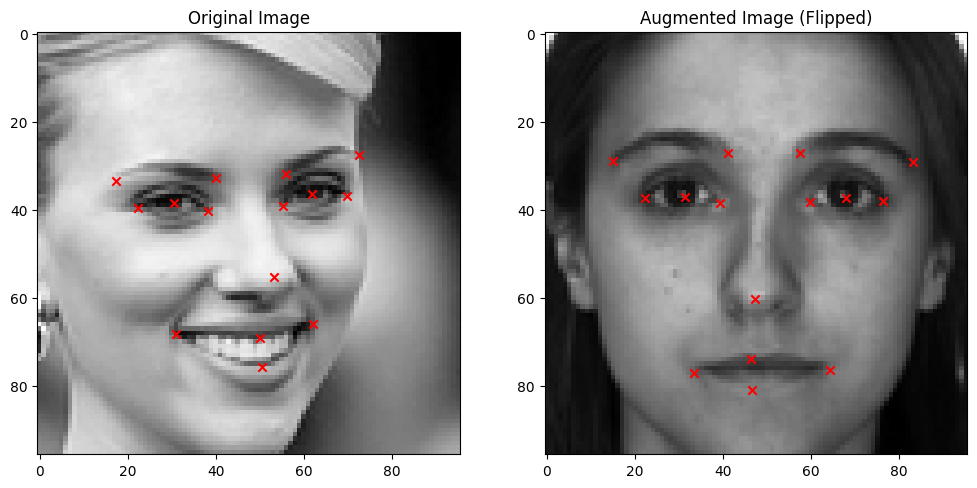

In [ ]:
import matplotlib.pyplot as plt

# Display original and augmented images with keypoints
plt.figure(figsize=(12, 6))

# Original image
original_index = 0  # Choose an index for the original image
original_image = x_train[original_index, :, :, 0]
original_keypoints = y_train[original_index].reshape(-1, 2) * 48 + 48  # Assuming keypoints are in range [-1, 1]
plt.subplot(1, 2, 1)
plt.imshow(original_image, cmap='gray')
plt.scatter(original_keypoints[:, 0], original_keypoints[:, 1], c='r', marker='x', label='Keypoints')
plt.title('Original Image')

# Augmented image and keypoints
augmented_image = augmented_x_train[100, :, :, 0]
augmented_keypoints = augmented_y_train[100].reshape(-1, 2) * 48 + 48  # Select the first augmented image and its keypoints

plt.subplot(1, 2, 2)
plt.imshow(augmented_image, cmap='gray')
plt.scatter(augmented_keypoints[:, 0], augmented_keypoints[:, 1], c='r', marker='x', label='Augmented Keypoints')
plt.title('Augmented Image (Flipped)')

plt.show()

In [ ]:
# training with data augmentation
batch_size = 128
epochs = 50
model.compile(loss=root_mean_squared_error, optimizer="adam")

model.fit(augmented_x_train, augmented_y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)

Epoch 1/50
22/22 [==============================] - 3s 82ms/step - loss: 0.1499 - val_loss: 0.0757
Epoch 2/50
22/22 [==============================] - 1s 64ms/step - loss: 0.0727 - val_loss: 0.0636
Epoch 3/50
22/22 [==============================] - 1s 64ms/step - loss: 0.0668 - val_loss: 0.0621
Epoch 4/50
22/22 [==============================] - 1s 66ms/step - loss: 0.0644 - val_loss: 0.0670
Epoch 5/50
22/22 [==============================] - 2s 69ms/step - loss: 0.0609 - val_loss: 0.0521
Epoch 6/50
22/22 [==============================] - 1s 68ms/step - loss: 0.0535 - val_loss: 0.0471
Epoch 7/50
22/22 [==============================] - 2s 69ms/step - loss: 0.0495 - val_loss: 0.0456
Epoch 8/50
22/22 [==============================] - 1s 66ms/step - loss: 0.0477 - val_loss: 0.0491
Epoch 9/50
22/22 [==============================] - 1s 66ms/step - loss: 0.0476 - val_loss: 0.0423
Epoch 10/50
22/22 [==============================] - 2s 75ms/step - loss: 0.0437 - val_loss: 0.0405
Epoch 11/

In [ ]:
y_new = model.predict(x_valid)

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 0s 7ms/step
Mean pixel error:  1.6605533


Once again, the resulting performance does not improve.

### 4th approach - use baseline model

Leverage transfer learning by using pretrained models like ResNet, or EfficientNet as a base and fine-tuning them on your dataset. This can provide a better starting point and improve generalization.

In [ ]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model

number_of_keypoints = 30

# Load ResNet50 with weights trained on ImageNet
base_model_rgb = ResNet50(weights='imagenet', include_top=False, input_shape=(96, 96, 3))

# Create an input layer for grayscale images (96x96x1)
input_layer_gray = Input(shape=(96, 96, 1))

# Repeat the grayscale channel to create a 3-channel image
input_layer_rgb = Conv2D(3, (1, 1), padding='same')(input_layer_gray)

# Connect the repeated grayscale input to ResNet50
output_resnet = base_model_rgb(input_layer_rgb)

# Additional layers for keypoints detection
x = Flatten()(output_resnet)
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(number_of_keypoints, activation='linear')(x)

# Create the model
model = Model(inputs=input_layer_gray, outputs=output)

# Compile and train the model
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])
model.fit(x_train, y_train, epochs=epochs, batch_size=batch_size, validation_data=(x_valid, y_valid))


Epoch 1/50
12/12 [==============================] - 45s 922ms/step - loss: 0.8567 - mae: 0.5464 - val_loss: 0.1472 - val_mae: 0.3316
Epoch 2/50
12/12 [==============================] - 3s 271ms/step - loss: 0.1471 - mae: 0.3302 - val_loss: 0.1409 - val_mae: 0.3235
Epoch 3/50
12/12 [==============================] - 3s 271ms/step - loss: 0.1407 - mae: 0.3218 - val_loss: 0.1345 - val_mae: 0.3148
Epoch 4/50
12/12 [==============================] - 3s 290ms/step - loss: 0.1343 - mae: 0.3130 - val_loss: 0.1282 - val_mae: 0.3059
Epoch 5/50
12/12 [==============================] - 4s 314ms/step - loss: 0.1279 - mae: 0.3041 - val_loss: 0.1220 - val_mae: 0.2970
Epoch 6/50
12/12 [==============================] - 3s 265ms/step - loss: 0.1218 - mae: 0.2952 - val_loss: 0.1161 - val_mae: 0.2882
Epoch 7/50
12/12 [==============================] - 3s 273ms/step - loss: 0.1159 - mae: 0.2864 - val_loss: 0.1103 - val_mae: 0.2794
Epoch 8/50
12/12 [==============================] - 3s 274ms/step - loss: 0

In [ ]:
y_new = model.predict(x_valid)

print("Mean pixel error: ", rmse_pixel(y_valid, y_new))

11/11 [==============================] - 2s 52ms/step
Mean pixel error:  5.322232


The fact that this approach does not improve the performance of the 1st approach could be due to several reasons.

Firstly, the pretrained model is trained on colored images while my input is in grayscale and I have had to do a modification based on that. Also, pretrained models are trained on general datasets like ImageNet. If the dataset significantly differs in domain or context, a custom model might better capture domain-specific features, they require substantial data for fine-tuning. In a small dataset, a custom model might generalize better due to its tailored architecture.

Looking at the loss, we could also be facing a little bit of overfitting.

# Reporting

Please, report the results of your experiments in this cell.

## What is the best result you got when testing?  

> Results must be evaluated by computing the **mean error in pixel units**. If you get a mean error of 1.6 pixels is ok. If your get 1.5 is very good. If you get 1.3 or less, it is an outstanding result!

**Answer**: The mean pixel error is ~1.5

## What architecture and tricks you used for that result?
### Describe your design strategy as well all those tricks that contributed to your result.

**Answer**: In depth description of the model and other approaches I have experimented are in the notebook (please read for more info).
A brief description of the approach that has had a better performance consist on adding depth into the original model provided (3 CNN2D layers) as well as a droput layer. As a training routine having early stopping also helps as the model tends to overfit due to the lack  and imbalance of data.

